## JPEG圧縮(Step.4)YCbCr+DCT+量子化

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def BGR2YCbCr(img):
    H, W, _ = img.shape
    ycbcr =  np.zeros([H, W, 3], dtype=np.float32)
    
    ycbcr[..., 0] = 0.299*img[..., 2] + 0.5870*img[..., 1] + 0.114*img[..., 0]
    ycbcr[..., 1] = -0.1687*img[..., 2] -0.3313*img[..., 1] + 0.5*img[..., 0] +128.
    ycbcr[..., 2] = 0.5*img[..., 2] -0.4187*img[..., 1] - 0.0813*img[..., 0] +128.
    
    return ycbcr

def YCbCr2BGR(ycbcr):
    H, W, _ = ycbcr.shape
    
    out = np.zeros([H, W, 3], dtype=np.float32)
    
    out[...,2] = ycbcr[..., 0] + (ycbcr[..., 2] - 128)*1.402
    out[...,1] = ycbcr[..., 0] - (ycbcr[..., 1] - 128)*0.3441 - (ycbcr[..., 2] - 128)*0.7139
    out[...,0] = ycbcr[..., 0] + (ycbcr[..., 1] - 128)*1.7718
    
     
    out = np.clip(out, 0, 255)
    # これをしないだけで図画全然違くなる
    out = out.astype(np.uint8)
    
    return out

In [13]:
# DCT hyoer-parameter
T = 8
K = 8
channel = 3

# DCT weight
def DCT_w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return (( 2 * cu * cv / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))

# DCT
def dct(img):
    H, W, _ = img.shape

    F = np.zeros((H, W, channel), dtype=np.float32)

    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for v in range(T):
                    for u in range(T):
                        for y in range(T):
                            for x in range(T):
                                F[v+yi, u+xi, c] += img[y+yi, x+xi, c] * DCT_w(x,y,u,v)

    return F


# IDCT
def idct(F):
    H, W, _ = F.shape

    out = np.zeros((H, W, channel), dtype=np.float32)

    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for y in range(T):
                    for x in range(T):
                        for v in range(K):
                            for u in range(K):
                                out[y+yi, x+xi, c] += F[v+yi, u+xi, c] * DCT_w(x,y,u,v)

    out = np.clip(out, 0, 255)
    out = np.round(out).astype(np.uint8)

    return out

# Quantization
def quantization(F):
    H, W, _ = F.shape

    Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
                (12, 12, 14, 19, 26, 58, 60, 55),
                (14, 13, 16, 24, 40, 57, 69, 56),
                (14, 17, 22, 29, 51, 87, 80, 62),
                (18, 22, 37, 56, 68, 109, 103, 77),
                (24, 35, 55, 64, 81, 104, 113, 92),
                (49, 64, 78, 87, 103, 121, 120, 101),
                (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

    for ys in range(0, H, T):
        for xs in range(0, W, T):
            for c in range(channel):
                F[ys: ys + T, xs: xs + T, c] =  np.round(F[ys: ys + T, xs: xs + T, c] / Q) * Q

    return F

def quantization2(F):
    H, W, _ = F.shape

    Q = np.array(((17, 18, 24, 47, 99,99,99,99),
                (18, 21, 26, 66, 99,99,99,99),
                (24, 26, 56, 99,99,99,99,99),
                (47, 66, 99,99,99,99,99,99),
                (99,99,99,99,99,99,99,99),
                (99,99,99,99,99,99,99,99),
                (99,99,99,99,99,99,99,99),
                (99,99,99,99,99,99,99,99)), dtype=np.float32)

    for ys in range(0, H, T):
        for xs in range(0, W, T):
            for c in range(channel):
                F[ys: ys + T, xs: xs + T, c] =  np.round(F[ys: ys + T, xs: xs + T, c] / Q) * Q

    return F

def JPEG(img):
    ycbcr = BGR2YCbCr(img)
    F = dct(ycbcr)
    F = quantization(F)
    ycbcr = idct(F)
    out = YCbCr2BGR(ycbcr)
    
    return out

def JPEG2(img):
    ycbcr = BGR2YCbCr(img)
    F = dct(ycbcr)
    F = quantization2(F)
    ycbcr = idct(F)
    out = YCbCr2BGR(ycbcr)
    
    return out




# MSE
def MSE(img1, img2):
    H, W, _ = img1.shape
    mse = np.sum((img1 - img2) ** 2) / (H * W * channel)
    return mse

# PSNR
def PSNR(mse, vmax=255):
    return 10 * np.log10(vmax * vmax / mse)

# bitrate
def BITRATE():
    return 1. * T * K * K / T / T

True

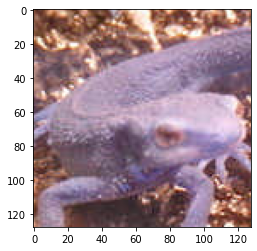

In [17]:
# どちらの変換でも背景が紫になってしまう
# img読み込むときのastype(np.float32)をしていなかったのが原因でした。
img = cv2.imread('../imori.jpg').astype(np.float32)
out = JPEG(img)

plt.imshow(out)
cv2.imwrite('out40_1.jpg', out)

True

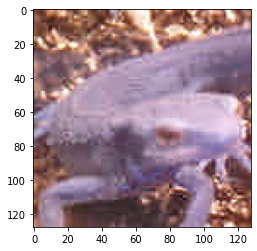

In [18]:
img = cv2.imread('../imori.jpg').astype(np.float32)
out = JPEG2(img)

plt.imshow(out)
cv2.imwrite('out40_1.jpg', out)

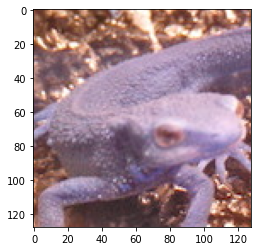

In [15]:
plt.imshow(img)

MSE: 64.06252034505208
PSNR: 30.064763402082775
bitrate: 8.0


True

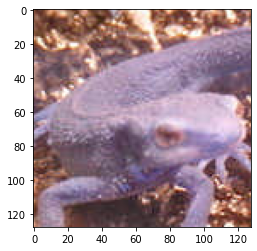

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# DCT hyoer-parameter
T = 8
K = 8
channel = 3


# BGR -> Y Cb Cr
def BGR2YCbCr(img):
  H, W, _ = img.shape

  ycbcr = np.zeros([H, W, 3], dtype=np.float32)

  ycbcr[..., 0] = 0.2990 * img[..., 2] + 0.5870 * img[..., 1] + 0.1140 * img[..., 0]
  ycbcr[..., 1] = -0.1687 * img[..., 2] - 0.3313 * img[..., 1] + 0.5 * img[..., 0] + 128.
  ycbcr[..., 2] = 0.5 * img[..., 2] - 0.4187 * img[..., 1] - 0.0813 * img[..., 0] + 128.

  return ycbcr

# Y Cb Cr -> BGR
def YCbCr2BGR(ycbcr):
  H, W, _ = ycbcr.shape

  out = np.zeros([H, W, channel], dtype=np.float32)
  out[..., 2] = ycbcr[..., 0] + (ycbcr[..., 2] - 128.) * 1.4020
  out[..., 1] = ycbcr[..., 0] - (ycbcr[..., 1] - 128.) * 0.3441 - (ycbcr[..., 2] - 128.) * 0.7139
  out[..., 0] = ycbcr[..., 0] + (ycbcr[..., 1] - 128.) * 1.7718

  out = np.clip(out, 0, 255)
  out = out.astype(np.uint8)

  return out


# DCT weight
def DCT_w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return (( 2 * cu * cv / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))

# DCT
def dct(img):
    H, W, _ = img.shape

    F = np.zeros((H, W, channel), dtype=np.float32)

    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for v in range(T):
                    for u in range(T):
                        for y in range(T):
                            for x in range(T):
                                F[v+yi, u+xi, c] += img[y+yi, x+xi, c] * DCT_w(x,y,u,v)

    return F


# IDCT
def idct(F):
    H, W, _ = F.shape

    out = np.zeros((H, W, channel), dtype=np.float32)

    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for y in range(T):
                    for x in range(T):
                        for v in range(K):
                            for u in range(K):
                                out[y+yi, x+xi, c] += F[v+yi, u+xi, c] * DCT_w(x,y,u,v)

    out = np.clip(out, 0, 255)
    out = np.round(out).astype(np.uint8)

    return out

# Quantization
def quantization(F):
    H, W, _ = F.shape

    Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
                (12, 12, 14, 19, 26, 58, 60, 55),
                (14, 13, 16, 24, 40, 57, 69, 56),
                (14, 17, 22, 29, 51, 87, 80, 62),
                (18, 22, 37, 56, 68, 109, 103, 77),
                (24, 35, 55, 64, 81, 104, 113, 92),
                (49, 64, 78, 87, 103, 121, 120, 101),
                (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

    for ys in range(0, H, T):
        for xs in range(0, W, T):
            for c in range(channel):
                F[ys: ys + T, xs: xs + T, c] =  np.round(F[ys: ys + T, xs: xs + T, c] / Q) * Q

    return F


# JPEG without Hufman coding
def JPEG(img):
    # BGR -> Y Cb Cr
    ycbcr = BGR2YCbCr(img)

    # DCT
    F = dct(ycbcr)

    # quantization
    F = quantization(F)

    # IDCT
    ycbcr = idct(F)

    # Y Cb Cr -> BGR
    out = YCbCr2BGR(ycbcr)

    return out


# MSE
def MSE(img1, img2):
    H, W, _ = img1.shape
    mse = np.sum((img1 - img2) ** 2) / (H * W * channel)
    return mse

# PSNR
def PSNR(mse, vmax=255):
    return 10 * np.log10(vmax * vmax / mse)

# bitrate
def BITRATE():
    return 1. * T * K * K / T / T


# Read image
img = cv2.imread("../imori.jpg").astype(np.float32)

# JPEG
out = JPEG(img)

# MSE
mse = MSE(img, out)

# PSNR
psnr = PSNR(mse)

# bitrate
bitrate = BITRATE()

print("MSE:", mse)
print("PSNR:", psnr)
print("bitrate:", bitrate)

# Save result
plt.imshow(out)
cv2.imwrite("out40_1.jpg", out)